#### This notebook is intended to be a demo for running the proposed methodology given time series data
#### Major components required for the end-to-end process include:
1. time series trajectories, see `data_demo/demo_seed0/trajs.pickle`
2. the corresponding `torch.utils.data.dataset.Dataset` object for loading the data during the run, see `src/datasets/demo.py`
3. the config file that specifies the data and (hyper)parameters, see `configs/demo.yaml`

In [1]:
import numpy as np
import glob
import pickle

# 0. Data Preparation
* For practical purpose, we generate synthetic data according to the LinearVAR setting described in the paper. In this demo, we consider a setup with **20 nodes and 5 entities**; the total number of available time series observations is 10k
* The exact DGP and the sample preparation parameters are specified in `./configs/demo.yaml` section `DGP`
* Note that our synthetic data pipeline entails two major pieces: (1) trajectory generation; and (2) sample preparation. In the case where one already has the trajectories, proceed with Step 2 directly

In [2]:
!head -23 configs/demo.yaml


DGP:
  dgp_str: 'LinearVAR'
  num_nodes: 20
  num_subjects: 5
  dispersion: 0.3
  perturb_support: True
  q_lags: 1
  sigLow: 1
  sigHigh: 2
  sigDecay: 1
  specr_common: 0.5
  sparsity_common: 0.1
  specr_max: 0.95
  sigma_obs: 1
  T_obs: 10000
  ## for sample preparation; reserve 2000 samples for validation and 1000 samples for testing
  num_train: 6971
  num_val: 2000
  num_test: 1000
  context_length: 30
  target_length: 0
  stride: 1


In [3]:
!python -u generator/generate_VAR.py --ds_str='demo' --seed=0

**Move the data to folder `data_demo/`** (in our experiment pipeline, simulated data would sit under `data_sim/` by default)

In [4]:
!mkdir -p data_demo
!mv data_sim/demo_seed0 data_demo/.
!rm -rf data_sim

## 0.1 Prepare the data

**The trajectories (i.e., input time series observations) are given as a dictionary, with each (key, value) corresponding to the (entity ID, multivariate time series observation for the entity)**

In [5]:
with open('data_demo/demo_seed0/trajs.pickle','rb') as handle:
    trajs = pickle.load(handle)
print(trajs.keys())

dict_keys([0, 1, 2, 3, 4])


In [6]:
type(trajs[0]), trajs[0].shape

(numpy.ndarray, (10000, 20))

**The prepared samples are in the form of "short" trajectories with the designated context length, separated into train/val/test data folders**
* See L106-L128 in `generator/generate_VAR.py` for an example of how the trajectories are parsed into samples

In [7]:
## take a look at what's in the train folder, showing the first 10
print(sorted(glob.glob('data_demo/demo_seed0/train/*.npy'))[:10])

['data_demo/demo_seed0/train/data_0.npy', 'data_demo/demo_seed0/train/data_1.npy', 'data_demo/demo_seed0/train/data_10.npy', 'data_demo/demo_seed0/train/data_100.npy', 'data_demo/demo_seed0/train/data_1000.npy', 'data_demo/demo_seed0/train/data_1001.npy', 'data_demo/demo_seed0/train/data_1002.npy', 'data_demo/demo_seed0/train/data_1003.npy', 'data_demo/demo_seed0/train/data_1004.npy', 'data_demo/demo_seed0/train/data_1005.npy']


In [8]:
## each data slices corresponds to a single "sample"; now take a look at the dimension of each data slice
data_slice = np.load('data_demo/demo_seed0/train/data_104.npy')
data_slice.shape # (num_entities, context_length, num_nodes)

(5, 30, 20)

## 0.2 Prepare the dataset class
* This is a short piece of code that will be later used for loading the above sample-level data into the dataloader
* The name of this Dataset object does NOT need to be identical to the name of the dataset (e.g., it can be used for multiple datasets as long as they all possess the same input format). See L51-L54 of `utils/realrunner.py` for more details on how the classname is determined; see L92 for an example of how the Dataset class is instantiated.
* Dont forget to add it to `__init__.py` in the folder

In [9]:
!cat src/datasets/demo.py

"""
Customized Dataset class for loading the trajectories of the demo dataset
"""

import os
import time
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

class demoMultiSub(Dataset):
    def __init__(
        self,
        ds_name,
        size,
        file_type = 'train',
    ):
        self.data_prefix = f'data_demo/{ds_name}/{file_type}/data_'
        self.list_of_ids = list(range(size))
        
    def __len__(self):
        return len(self.list_of_ids)

    def __getitem__(self, index):
        idx = self.list_of_ids[index]
        data = np.load(self.data_prefix + str(idx) + '.npy')
        data = torch.from_numpy(data).to(dtype=torch.float32)
        return data

class demoOneSub(Dataset):
    def __init__(
        self,
        ds_name,
        size,
        file_type = 'train',
        subject_id = 0
    ):
        self.data_prefix = f'data_demo/{ds_name}/{file_type}/data_'
        self.sample_s

# 1. Run the model
* Here we use 3000 samples to train; certain hyper-parameters are set small intentionally so that the network is not too big
* The specifications of output_dir and config are optional, in which case defaults will be used

In [10]:
## train with the proposed Multi-Entity VAE-based framework
!python -u train.py --ds_str='demo' --train_size=3000 --cuda=0 --output_dir='output_demo/MultiSub' --config='./configs/demo.yaml'

In [11]:
## train with the single-Entity VAE-based framework for entity 0
!python -u train_one.py --ds_str='demo' --train_size=3000 --subject_id=0 --cuda=0 --output_dir='output_demo/OneSub/subject_0' --config='./configs/demo_oneSub.yaml'

In [12]:
!tree output_demo

output_demo
├── MultiSub
│   ├── args.json
│   ├── ckpts
│   │   ├── ckpt-best.ckpt
│   │   └── ckpt-last.ckpt
│   ├── test_barGraphs.npy
│   ├── test_subjGraphs.npy
│   ├── test_xPredsMean.npy
│   └── test_xTargets.npy
└── OneSub
    └── subject_0
        ├── args.json
        ├── ckpts
        │   ├── ckpt-best.ckpt
        │   └── ckpt-last.ckpt
        ├── test_subjGraphs.npy
        ├── test_xPredsMean.npy
        └── test_xTargets.npy

6 directories, 13 files


# 2. Collect the results and plot

In [13]:
from sklearn import metrics

In [14]:
from utils.utils_plot import *
from utils.utils_eval import gather_vaeGraphs
import matplotlib.pyplot as plt

In [15]:
figsize=(12,2)

## 2.1 Plot the underlying truth

In [16]:
data_folder = 'data_demo/demo_seed0'
GC_bar = np.load(f'{data_folder}/A_bar.npy')
GC_by_subj = np.load(f'{data_folder}/A_by_subject.npy')

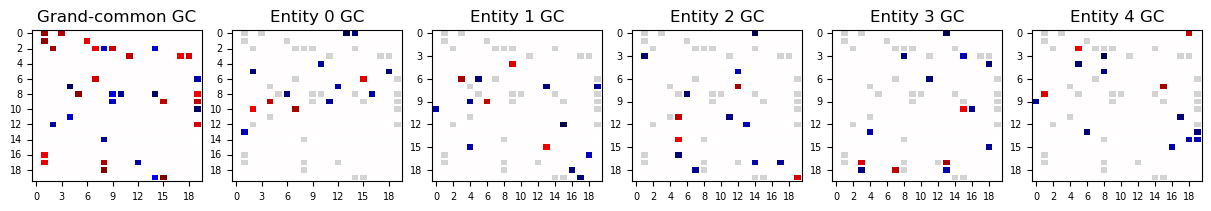

In [17]:
fig, axs = plt.subplots(1,6,figsize=figsize,constrained_layout=True)
get_heatmap(GC_bar, axs_to_plot=axs[0],threshold=1.0e-6,annot=False)
axs[0].set_title('Grand-common GC')
for i in range(5):
    get_heatmap_with_mask(GC_by_subj[i], GC_bar, axs_to_plot=axs[i+1],threshold=1.0e-6)
    axs[i+1].set_title(f'Entity {i} GC')
plt.show()

## 2.2 Gather results from the model

In [18]:
n_nodes, n_subjects = 20, 5

In [19]:
estGC_by_subj, estGC_bar = gather_vaeGraphs('output_demo/MultiSub', n_nodes, n_subjects, runType='multi')

In [20]:
estGC_by_subj.shape, estGC_bar.shape

((5, 20, 20), (20, 20))

### Evaluate
* showing evaluation of the common graph $\bar{\mathbf{z}}$

In [21]:
## AUROC
auroc = metrics.roc_auc_score(1*(GC_bar!=0).ravel(), np.abs(estGC_bar).ravel())
print(f'AUROC={auroc*100:.2f}%')

AUROC=99.96%


In [22]:
## AUPRC
auroc = metrics.average_precision_score(1*(GC_bar!=0).ravel(), np.abs(estGC_bar).ravel())
print(f'AUROC={auroc*100:.2f}%')

AUROC=99.59%


### Plot
* Note that the proposed methodology can recover the true signs _up to_ a complete sign flip (see Appendix E of the paper) and preseverse the positive/negative "clusters". This shows up in this specific run, where all negatives are identified as "red" and positives are identified as "blue", which corresponds to a complete sign flip relative to the truth. 

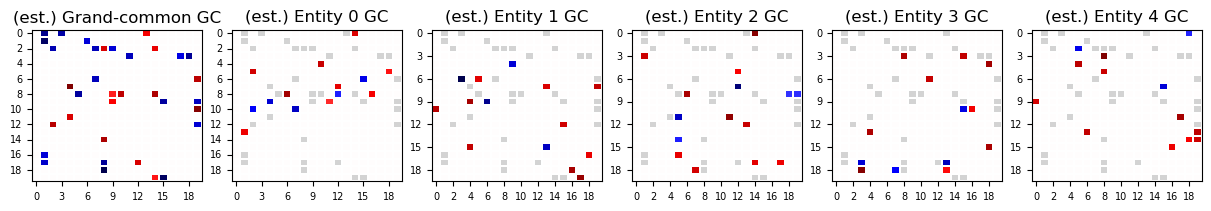

In [23]:
fig, axs = plt.subplots(1,6,figsize=figsize,constrained_layout=True)
get_heatmap(estGC_bar, axs_to_plot=axs[0],threshold=0.40,annot=False)
axs[0].set_title('(est.) Grand-common GC')
for i in range(5):
    get_heatmap_with_mask(estGC_by_subj[i], 1*(np.abs(estGC_bar)>=0.40), axs_to_plot=axs[i+1],threshold=0.40)
    axs[i+1].set_title(f'(est.) Entity {i} GC')
plt.show()